Title (Steve, Eva, Liam, Jacky)

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question

Methods & Results:

describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

#### 1. loading in all the packages for data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
library(kknn)
library(purrr)

#### 2. Reading in the data from the web, and Making "UNS" a factor

In [3]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"

knowledge_data<-read_csv(url)|>
    select(STG:UNS)|>
    mutate(UNS = as.factor(UNS))

#### 3. Spliting the data into 70% properation of training data and testing data

In [4]:
knowledge_data_split <- initial_split(knowledge_data, prop = 0.70, strata = UNS)  
   knowledge_data_split_train <- training(knowledge_data_split)
   knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.50,0.20,0.85,High
0.18,0.18,0.55,0.30,0.81,High
0.05,0.07,0.70,0.01,0.05,very_low
⋮,⋮,⋮,⋮,⋮,⋮
0.68,0.43,0.60,0.47,0.55,Middle
0.66,0.68,0.81,0.57,0.57,Middle
NA,NA,NA,NA,NA,NA


 #### 4. Seting up the k-nearest_neighbor model for finding the optimal K-value

x Fold5: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ℹ In argument: `.row = orig_rows`.
  Caused by error:
  ! `.row` must be size 55 or 1, not 56.



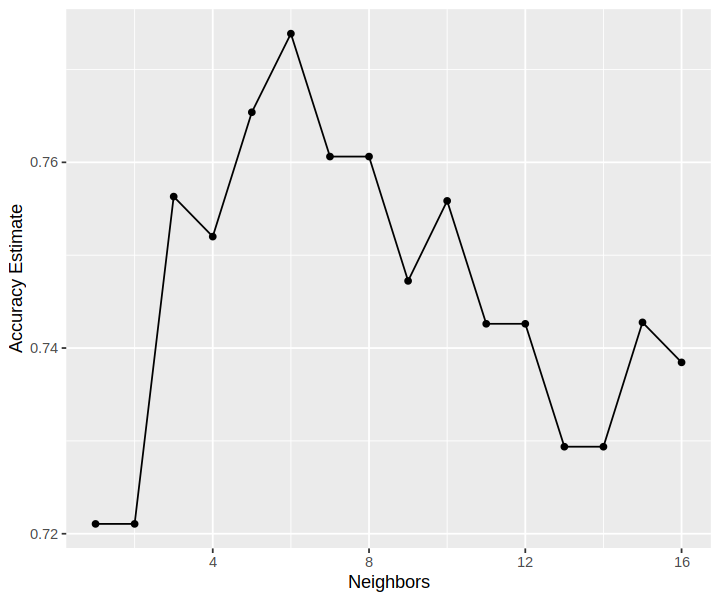

In [5]:

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
    step_center(all_predictors())|>
    step_scale(all_predictors())

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

K <- tibble(neighbors = seq(1,16))

knn_result <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_tune)|>
    tune_grid(resamples = training_vfold, grid = K) |>
    collect_metrics()|>
    filter(.metric == "accuracy")


#### 5. Visualizing the optimal K-value

In [ ]:
cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
    geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
cross_val_plot

#### 6. Creating the model with the optimal K-value

In [6]:
knn_best_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification")


knn_fit <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_best_tune)|>
    fit(knowledge_data_split_train)

#### 7. Predicting the model on the testing data set

In [14]:
test_prediction <- predict(knn_fit, knowledge_data_split_test)|>
    bind_cols(knowledge_data_split_test)
test_prediction

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.00,0.00,0.00,0.0,very_low
Middle,0.08,0.08,0.10,0.24,0.9,High
Middle,0.10,0.10,0.15,0.65,0.3,Middle
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.58,0.40,0.32,0.22,0.24,Low
High,0.85,0.82,0.66,0.83,0.83,High
Middle,0.68,0.64,0.79,0.97,0.24,Middle


#### 8. Evaluating the model

In [16]:
mnist_metrics  <- test_prediction |>
    metrics(truth = UNS, estimate = .pred_class)
mnist_metrics

mnist_conf_mat <- test_prediction|>
    conf_mat(truth = UNS, estimate = .pred_class)

mnist_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7377049
kap,multiclass,0.6337024


          Truth
Prediction High Low Middle Very Low very_low
  High       26   0      4        0        0
  Low         0  36      8        8        4
  Middle      5   0     27        0        0
  Very Low    0   0      0        0        3
  very_low    0   0      0        0        1

Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.